In [2]:
import pandas as pd
import numpy as np
import random

# Models
from sklearn import ensemble
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import ElasticNet
import xgboost as xg
from sklearn.metrics import r2_score, mean_squared_error, mean_gamma_deviance

# Data Vis
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_ts = pd.read_csv("/content/taylor_swift_spotify.csv",index_col=0 ) #sep="\t")
df_ts.head(2)

,name,album,release_date,track_number,id,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms
0,Lavender Haze,Midnights (The Til Dawn Edition),2023-05-26,1,24emu3sabKISjRkrys28jq,spotify:track:24emu3sabKISjRkrys28jq,0.2360,0.735,0.454,0.001130,0.133,-10.516,0.0876,97.043,0.0751,74,202395
1,Maroon,Midnights (The Til Dawn Edition),2023-05-26,2,6qxvy9Pe4RJIq5JBVbbwbS,spotify:track:6qxvy9Pe4RJIq5JBVbbwbS,0.0609,0.650,0.397,0.000001,0.089,-8.237,0.0365,108.055,0.0382,73,218270


In [4]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465 entries, 0 to 464
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              465 non-null    object 
 1   album             465 non-null    object 
 2   release_date      465 non-null    object 
 3   track_number      465 non-null    int64  
 4   id                465 non-null    object 
 5   uri               465 non-null    object 
 6   acousticness      465 non-null    float64
 7   danceability      465 non-null    float64
 8   energy            465 non-null    float64
 9   instrumentalness  465 non-null    float64
 10  liveness          465 non-null    float64
 11  loudness          465 non-null    float64
 12  speechiness       465 non-null    float64
 13  tempo             465 non-null    float64
 14  valence           465 non-null    float64
 15  popularity        465 non-null    int64  
 16  duration_ms       465 non-null    int64  
dt

<Axes: xlabel='popularity', ylabel='Count'>

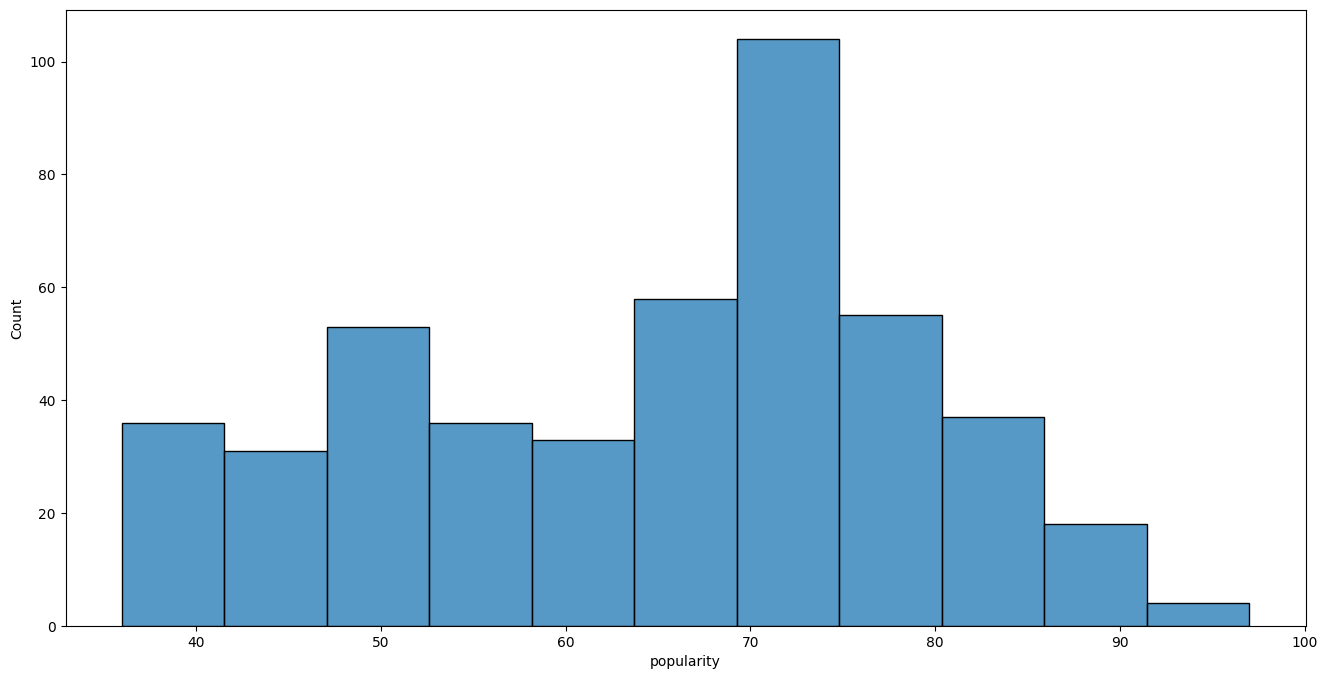

In [5]:
plt.figure(figsize=(16, 8))
sns.histplot(df_ts["popularity"],bins='auto')

Popularity of the songs varies widely due to different versions of songs, such as karaoke and international releases. Factors like regional preferences, language, and timing of releases influence popularity scores. Considering these factors provides insights into audience preferences and music trends.

<ipython-input-6-b5cde0cedcc3>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_ts.corr()


<Axes: >

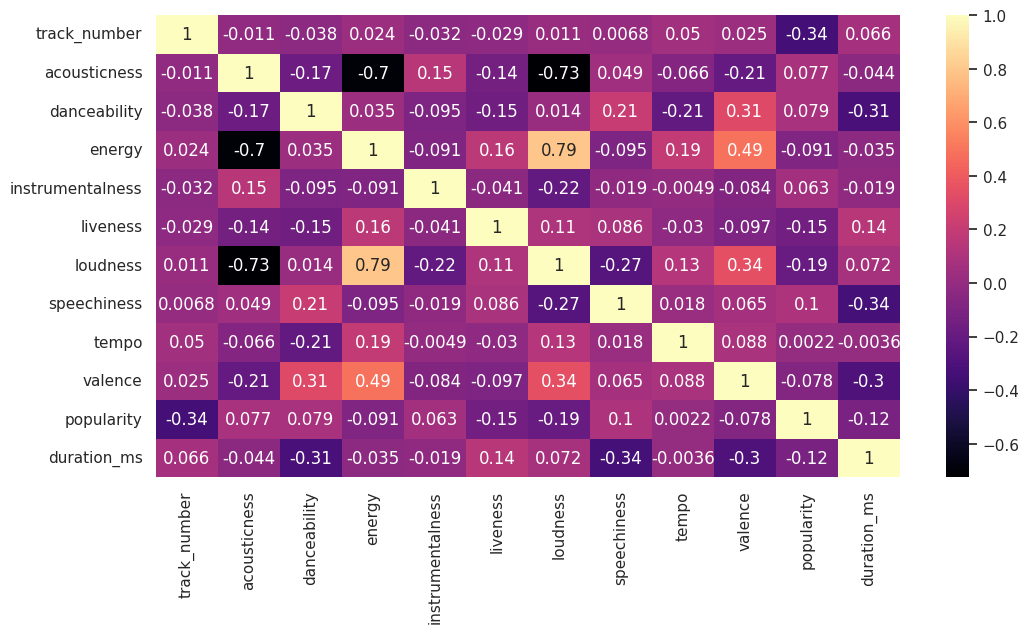

In [6]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
corr = df_ts.corr()
sns.heatmap(corr,annot=True,cmap="magma")

1) Loudness and energy exhibit a strong positive correlation of 0.80, implying that as the loudness of a song increases, its energy tends to increase as well.

2) Acousticness demonstrates a strong negative correlation with both loudness and energy, with correlation coefficients of -0.72 and -0.73, respectively. This suggests that as a song becomes more acoustic, its loudness and energy levels decrease.

3) The instrumental nature of a song has a negative impact on its popularity, as indicated by a correlation coefficient of -0.53. This implies that songs with fewer vocals and more instrumental elements tend to be less popular.

4) Speechiness exhibits a very strong negative correlation of -0.73 with the length of a song, implying that songs with more speech-like elements (e.g., spoken word) tend to be shorter in duration.

5) The track number on an album does not significantly impact the other features, suggesting that it has little to no correlation with loudness, energy, acousticness, popularity, and speechiness of the song.

# **FEATURE ENGINEERING**

In [7]:
df_ts['album'].value_counts()

reputation Stadium Tour Surprise Song Playlist                                         46
folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]    34
Red (Taylor's Version)                                                                 30
Fearless (Taylor's Version)                                                            26
Midnights (The Til Dawn Edition)                                                       23
Red (Deluxe Edition)                                                                   22
Speak Now (Deluxe Edition)                                                             20
Midnights (3am Edition)                                                                20
Fearless Platinum Edition                                                              19
1989 (Deluxe Edition)                                                                  19
Lover                                                                                  18
evermore (

1) In order to eliminate any bias from karaoke versions, we will exclude albums with the term 'karaoke' in their names from the dataset. This step aims to ensure fair correlations with speechiness and prevent any influence on popularity predictions.

2) By filtering out albums containing the string 'karaoke', we can remove any potential distortion in the analysis caused by these versions. This approach will enhance the accuracy of our correlations and predictive modeling regarding speechiness and overall popularity.

3) We will create a new DataFrame that omits rows with album names containing 'karaoke' to maintain the integrity of our analysis. This strategy allows us to focus on non-karaoke versions, reducing the risk of skewed results in our correlation and prediction models.

In [8]:
#df_ts2 = df_ts[~df_ts['album'].str.contains("Karaoke")]

In [9]:
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4), sharey=True)

#sns.histplot(df_ts["popularity"],bins='auto', ax=axes[0])
#sns.histplot(df_ts2["popularity"],bins='auto', ax=axes[1])

#axes[0].set_title('Raw Popularity')
#axes[1].set_title('Cleaned Popularity')


Date/Time Manipulation
I am going to separate the release_date feature into day/month/year of release to see if this gives us any further improvements when model building.

In [10]:
# Convert the release_date to datetime type
df_ts['release_date'] = pd.to_datetime(df_ts['release_date'])

In [11]:
month_of_release = df_ts['release_date'].dt.month
day_of_month = df_ts['release_date'].dt.day
year_of_release = df_ts['release_date'].dt.year

Text(0.5, 1.0, 'Year of release')

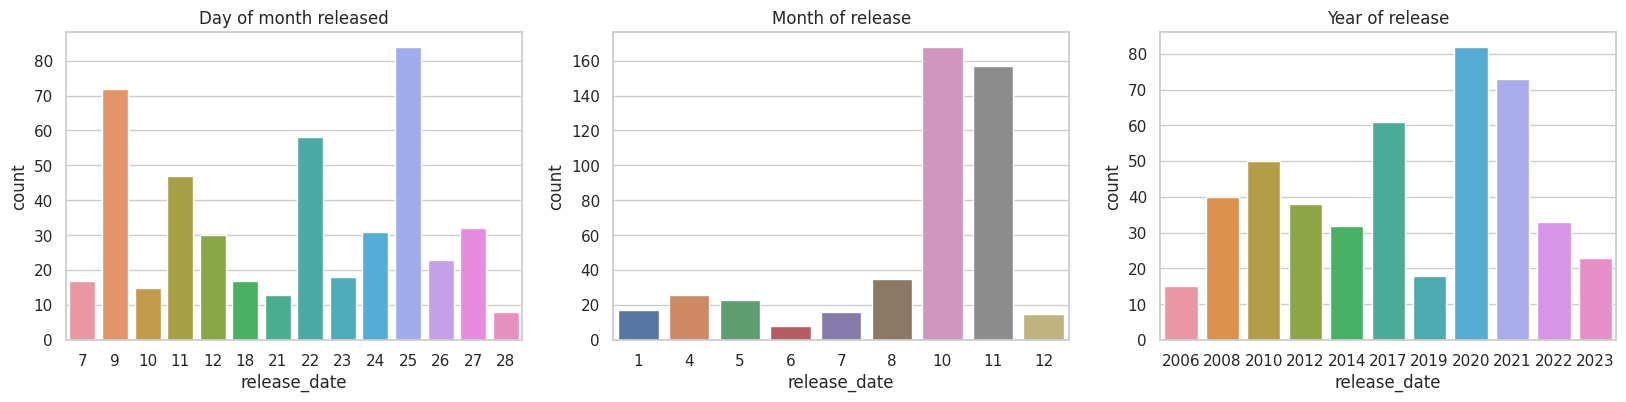

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,4), sharey=False)

sns.countplot(x=day_of_month, ax=axes[0])
sns.countplot(x=month_of_release, ax=axes[1])
sns.countplot(x=year_of_release, ax=axes[2])

axes[0].set_title('Day of month released')
axes[1].set_title('Month of release')
axes[2].set_title('Year of release')

In [13]:
# Drop some unnecessary columns that are not required when building the models
df = pd.DataFrame(df_ts.drop(columns=['name', 'id', 'uri']))

In [14]:
ohe_album = pd.get_dummies(df['album'])

In [15]:
features = pd.DataFrame({
    'track_number': df_ts['track_number'],
    'acousticness': df_ts['acousticness'],
    'danceability': df_ts['danceability'],
    'energy': df_ts['energy'],
    'instumentalness': df_ts['instrumentalness'],
    'liveness': df_ts['liveness'],
    'loudness': df_ts['loudness'],
    'speechiness': df_ts['speechiness'],
    'tempo': df_ts['tempo'],
    'valence': df_ts['valence'],
    'duration_ms': df_ts['duration_ms'],
    'month_of_release': month_of_release,
    'day_of_month': day_of_month,
    'year_of_release': year_of_release
})


In [16]:
final_df = pd.concat([features, ohe_album], axis=1)
final_df.columns = final_df.columns.str.replace(' ', '_')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465 entries, 0 to 464
Data columns (total 38 columns):
 #   Column                                                                               Non-Null Count  Dtype  
---  ------                                                                               --------------  -----  
 0   track_number                                                                         465 non-null    int64  
 1   acousticness                                                                         465 non-null    float64
 2   danceability                                                                         465 non-null    float64
 3   energy                                                                               465 non-null    float64
 4   instumentalness                                                                      465 non-null    float64
 5   liveness                                                                             465 non

In [17]:
X_train, X_test, y_train, y_test = train_test_split(final_df, df_ts['popularity'], test_size=0.1, random_state=42)

In [18]:
# Check the lengths of training/test data is as expected
print("Length of the X_train:", X_train.shape)
print("Length of the y_train:", y_train.shape)
print("Length of the X_test:", X_test.shape)
print("Length of the y_test:", y_test.shape)

Length of the X_train: (418, 38)
Length of the y_train: (418,)
Length of the X_test: (47, 38)
Length of the y_test: (47,)


# **MODEL EVUALUATION AND BUILDING**

In this section, I will build multiple models, utilize a function to store and present the Mean Squared Error, Root Mean Squared Error, and R2 score for each model. Lastly, I will create visualizations to compare the models' performance and determine which one performs the best, using a basic set of hyperparameters.

In [19]:
names, mses, rmses, r2s = [], [], [], []

In [20]:
def display_metrics(y_test, y_preds, model_type):
    mse = mean_squared_error(y_test, y_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_preds)
    result = f'''
    {model_type} MSE  : {mse}
    {model_type} RMSE : {rmse}
    {model_type} R^2  : {r2}
    '''

    names.append(model_type)
    mses.append(mse)
    rmses.append(rmse)
    r2s.append(r2)

    print(result)

LINEAR REGRESSION

In [21]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

In [22]:
display_metrics(y_test, lr_preds, "Linear Regression")


    Linear Regression MSE  : 19.173704268368265
    Linear Regression RMSE : 4.378778855841919
    Linear Regression R^2  : 0.8867145451197042
    


*ELASTIC NET REGRESSION*

In [23]:
elr = ElasticNet(alpha=0.1, random_state=42)
elr.fit(X_train, y_train)
elr_preds = elr.predict(X_test)

In [24]:
display_metrics(y_test, elr_preds, "Elastic Net Regression")


    Elastic Net Regression MSE  : 68.09397681674126
    Elastic Net Regression RMSE : 8.251907465352557
    Elastic Net Regression R^2  : 0.5976751789679426
    


*SUPPORT VECTOR REGRESSOR*

In [25]:
svr = SVR()
svr.fit(X_train, y_train)
svr_preds = svr.predict(X_test)

In [26]:
display_metrics(y_test, svr_preds, "Support Vector Regressor")


    Support Vector Regressor MSE  : 162.73848568351528
    Support Vector Regressor RMSE : 12.756899532547683
    Support Vector Regressor R^2  : 0.03847983054572823
    


*Decision Tree Regressor*

In [27]:
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_train, y_train)
dtr_preds = dtr.predict(X_test)

In [28]:
display_metrics(y_test, dtr_preds, "Decision Tree Regressor")


    Decision Tree Regressor MSE  : 35.829787234042556
    Decision Tree Regressor RMSE : 5.98579879665551
    Decision Tree Regressor R^2  : 0.7883041436198097
    


*Random Forest Regressor*

In [29]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)
rfr_preds = rfr.predict(X_test)
display_metrics(y_test, rfr_preds, "Random Forest Regressor")


    Random Forest Regressor MSE  : 27.032585106382978
    Random Forest Regressor RMSE : 5.199286980575604
    Random Forest Regressor R^2  : 0.8402813218821213
    


*XGB Regressor*

In [30]:
# Need to strip out []'s from the column names for compatability
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [31]:
xgb = xg.XGBRegressor()
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
display_metrics(y_test, xgb_preds, "XGB Regressor")


    XGB Regressor MSE  : 35.57614066815059
    XGB Regressor RMSE : 5.964573804401333
    XGB Regressor R^2  : 0.7898027829121295
    


*Gradient Boosting Regressor¶*

In [32]:
params = {'n_estimators': 660,
          'max_depth': 3,
          'min_samples_split': 3,
          'min_samples_leaf': 2,
          'learning_rate': 0.01
         } # instantiate and train the model
gbd_reg = ensemble.GradientBoostingRegressor(**params)
gbd_reg.fit(X_train, y_train)
gbd_preds = gbd_reg.predict(X_test)
display_metrics(y_test, gbd_preds, "Gradient Boosting Descent")



    Gradient Boosting Descent MSE  : 33.061530590834586
    Gradient Boosting Descent RMSE : 5.749915702932921
    Gradient Boosting Descent R^2  : 0.8046600448406594
    


In [34]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=1,cols=3, subplot_titles=('MSE', "RMSE", "R2"))

fig.add_bar(x=names, y=mses, row=1, col=1)
fig.add_bar(x=names, y=rmses, row=1, col=2)
fig.add_bar(x=names, y=r2s, row=1, col=3)

CONCLUSION:
According to the graph, the Linear Regression model demonstrated the best performance among the listed models, outperforming all others in all three evaluation metrics: mean squared error (MSE), mean absolute error (MAE), and R-squared (R2) score. The Gradient Boosted Descent model closely followed as the second-best performer.

On the other hand, the single Decision Tree Classifier exhibited the worst performance, with a low R2 score. This R2 score suggests that the model's predictions were less accurate compared to a simple approach of predicting the mean value of the dependent variable.

It's essential to keep in mind that model performance can vary depending on the dataset and the specific problem being addressed. To ensure a reliable assessment of the models, cross-validation and additional evaluation metrics should be considered during the model selection process.